In [1]:
import numpy as np
import xarray as xr
import time
from scipy.ndimage import convolve1d

def lanczos_low_pass_weights(window, cutoff):
    """
    Calculate weights for a low pass Lanczos filter.
    Inputs:
    ================
    window: int
        The length of the filter window (odd number).
    cutoff: float
        The cutoff frequency(1/cut off time steps)
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
#     sigma = 1.   # edit for testing to match with Charlotte ncl code
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]


def lanczos_filter_4d(da_var_anom, window, cutoff):

    wt = lanczos_low_pass_weights(window, cutoff)

    var_anom_filtered = convolve1d(
            da_var_anom.astype('float32').data,
            wt,
            axis=0,
            output='float32')

    da_var_anom_filtered = da_var_anom.copy(data=var_anom_filtered)

    return da_var_anom_filtered


In [26]:
ds = xr.open_dataset('./data/q_ml_1984_rechunked.nc').isel(longitude=slice(0,50),latitude=slice(0,50)).load()

In [28]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 50, level: 60, longitude: 50, time: 1464)
Coordinates:
  * latitude   (latitude) float64 90.0 89.25 88.5 87.75 ... 54.75 54.0 53.25
  * level      (level) int32 1 2 3 4 5 6 7 8 9 10 ... 52 53 54 55 56 57 58 59 60
  * longitude  (longitude) float64 0.0 0.75 1.5 2.25 ... 34.5 35.25 36.0 36.75
  * time       (time) datetime64[ns] 1984-01-01 ... 1984-12-31T18:00:00
Data variables:
    q          (time, level, latitude, longitude) float32 3.801e-06 ... 0.001398
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-17 11:31:00 GMT by grib_to_netcdf-2.26.0: grib_to_n...

In [27]:
# calculate ano and low pass
window = 96+96+1
cutoff = 1/(8*4)   # 6hourly daily data (4 times daily) for 8 days
da_anom = ds.q - ds.q.mean(dim='time')
%time da_anom_lowpass = lanczos_filter_4d(da_anom,window,cutoff)


CPU times: user 14.9 s, sys: 115 ms, total: 15 s
Wall time: 15 s


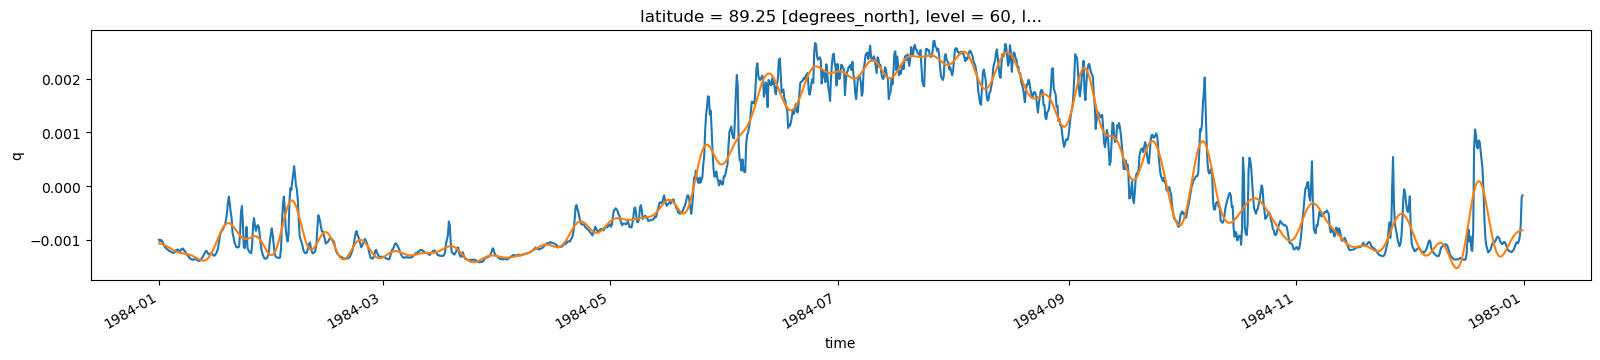

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_axes([0,0,1,0.5])
da_anom.isel(longitude=1,latitude=1,level=59).plot(ax=ax1)
da_anom_lowpass.isel(longitude=1,latitude=1,level=59).plot(ax=ax1)